# Level-2 Lasserre (Moment/SOS) SDP for Discretized $C_{1a}$

The Shor (level-1) SDP gives bound $2P/(2P-1) \to 1$, which is useless.
Level 2 constrains fourth-order moments via a larger moment matrix $M_2$,
preventing the uniform anti-diagonal spreading that defeated Shor.

**Key idea:** $M_2$ is indexed by monomials of degree $\leq 2$. Entry $(\alpha,\beta) = E[x^{\alpha+\beta}]$.
Moment consistency + PSD + localizing matrices for $x_i \geq 0$ **and** $\eta - p_k(x) \geq 0$ give a much tighter relaxation.

**Formulation note:** The constraints $\eta \geq p_k(x)$ must be enforced via
localizing matrices $M_1((\eta - p_k) \cdot \mu) \succeq 0$, not mere scalar
inequalities $\eta \geq \mathbb{E}[p_k]$. The scalar version collapses to Shor.
Since $\eta$ appears bilinearly with the moment variables, we use binary search on $\eta$.

In [1]:
"""Cell 1: Imports."""
import sys, os
import numpy as np
import cvxpy as cp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
import time

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.representations import StepFunction
from src.convolution import peak_autoconv_exact

print(f"cvxpy version: {cp.__version__}")

cvxpy version: 1.8.1


In [2]:
"""Cell 2: Monomial basis helpers."""

def monomial_basis(P, max_deg):
    """Enumerate monomials of degree <= max_deg in P variables.
    Each monomial is a sorted tuple of variable indices.
    E.g. x_0^2 x_1 -> (0, 0, 1).  Constant -> ().
    """
    basis = [()]
    for deg in range(1, max_deg + 1):
        for combo in combinations_with_replacement(range(P), deg):
            basis.append(combo)
    return basis


def combine(*multi_indices):
    """Combine multi-indices by concatenation and sorting."""
    return tuple(sorted(sum(multi_indices, ())))


# Sanity checks
print("P=2, deg<=2:", monomial_basis(2, 2))
print("combine((0,), (1,)):", combine((0,), (1,)))
print("combine((0,0), (1,)):", combine((0,0), (1,)))
print("combine((0,), (0,)):", combine((0,), (0,)))

# Check sizes
for P in range(2, 7):
    d = 1 + P + P*(P+1)//2
    print(f"P={P}: d={d}, M is {d}x{d}")

P=2, deg<=2: [(), (0,), (1,), (0, 0), (0, 1), (1, 1)]
combine((0,), (1,)): (0, 1)
combine((0,0), (1,)): (0, 0, 1)
combine((0,), (0,)): (0, 0)
P=2: d=6, M is 6x6
P=3: d=10, M is 10x10
P=4: d=15, M is 15x15
P=5: d=21, M is 21x21
P=6: d=28, M is 28x28


In [3]:
"""Cell 3: Level-2 Lasserre SDP solver with proper localizing matrices."""

def solve_lasserre_2(P, solver=None, verbose=False, eta_tol=1e-6):
    """Level-2 Lasserre SDP relaxation for discretized C_1a.
    
    The epigraph constraints η - p_k(x) ≥ 0 are enforced via localizing
    matrices M_1((η - p_k) · μ) ≥ 0, not scalar inequalities η ≥ E[p_k].
    Since this creates a bilinear dependence on (η, y), we binary search on η,
    solving an SDP feasibility problem at each step.
    
    Returns dict with 'bound', 'first_moments', 'Y', 'M', 'M_rank', etc.
    """
    # -- Bases --
    basis_2 = monomial_basis(P, 2)   # for M_2
    d = len(basis_2)                 # 1 + P + P(P+1)/2
    basis_1 = monomial_basis(P, 1)   # for localizing matrices
    loc_d = len(basis_1)             # 1 + P
    all_beta = monomial_basis(P, 3)  # for simplex equality constraints
    
    # -- Collect all unique moments needed (degree <= 4) --
    moments_set = set()
    # From M_2
    for i in range(d):
        for j in range(i, d):
            moments_set.add(combine(basis_2[i], basis_2[j]))
    # From localizing matrices for x_k >= 0
    for k in range(P):
        for a in range(loc_d):
            for b in range(a, loc_d):
                moments_set.add(combine((k,), basis_1[a], basis_1[b]))
    # From simplex equality constraints
    for beta in all_beta:
        moments_set.add(beta)
        for i in range(P):
            moments_set.add(combine((i,), beta))
    # From localizing matrices for η - p_k(x) >= 0
    for k_conv in range(2 * P - 1):
        for a in range(loc_d):
            for b in range(a, loc_d):
                moments_set.add(combine(basis_1[a], basis_1[b]))
                for i in range(P):
                    j_val = k_conv - i
                    if 0 <= j_val < P:
                        moments_set.add(combine(basis_1[a], basis_1[b], (i,), (j_val,)))
    
    moments_list = sorted(moments_set, key=lambda m: (len(m), m))
    moment_idx = {m: idx for idx, m in enumerate(moments_list)}
    n_mom = len(moments_list)
    print(f"  P={P}: d={d}, loc_d={loc_d}, n_moments={n_mom}")
    
    # -- Pre-compute indicator matrices (independent of η) --
    
    # M_2 indicator matrices
    B_M = {}
    for i in range(d):
        for j in range(i, d):
            mu = combine(basis_2[i], basis_2[j])
            idx = moment_idx[mu]
            if idx not in B_M:
                B_M[idx] = np.zeros((d, d))
            B_M[idx][i, j] = 1
            if i != j:
                B_M[idx][j, i] = 1
    
    # x_k >= 0 localizing indicator matrices
    B_Locs = []
    for k in range(P):
        B_L = {}
        for a in range(loc_d):
            for b in range(a, loc_d):
                mu = combine((k,), basis_1[a], basis_1[b])
                idx = moment_idx[mu]
                if idx not in B_L:
                    B_L[idx] = np.zeros((loc_d, loc_d))
                B_L[idx][a, b] = 1
                if a != b:
                    B_L[idx][b, a] = 1
        B_Locs.append(B_L)
    
    # Simplex equality constraint index data
    simplex_data = []
    for beta in all_beta:
        lhs_indices = [moment_idx[combine((i,), beta)] for i in range(P)]
        rhs_idx = moment_idx[beta]
        simplex_data.append((lhs_indices, rhs_idx))
    
    # M_1 indicator matrices (η coefficient in localizing matrices)
    B_M1 = {}
    for a in range(loc_d):
        for b in range(a, loc_d):
            mu = combine(basis_1[a], basis_1[b])
            idx = moment_idx[mu]
            if idx not in B_M1:
                B_M1[idx] = np.zeros((loc_d, loc_d))
            B_M1[idx][a, b] = 1
            if a != b:
                B_M1[idx][b, a] = 1
    
    # p_k indicator matrices for each anti-diagonal k
    B_pks = []
    for k_conv in range(2 * P - 1):
        B_pk = {}
        for a in range(loc_d):
            for b in range(a, loc_d):
                for i in range(P):
                    j_val = k_conv - i
                    if 0 <= j_val < P:
                        mu = combine(basis_1[a], basis_1[b], (i,), (j_val,))
                        idx = moment_idx[mu]
                        if idx not in B_pk:
                            B_pk[idx] = np.zeros((loc_d, loc_d))
                        B_pk[idx][a, b] += 1
                        if a != b:
                            B_pk[idx][b, a] += 1
        B_pks.append(B_pk)
    
    # -- Build CVXPY problem with η as a Parameter --
    y = cp.Variable(n_mom)
    eta_param = cp.Parameter(nonneg=True)
    constraints = []
    
    # M_2 >> 0
    M_expr = sum(y[idx] * mat for idx, mat in B_M.items())
    constraints.append(M_expr >> 0)
    constraints.append(y[moment_idx[()]] == 1)
    
    # Localizing matrices for x_k >= 0
    for B_L in B_Locs:
        L_k = sum(y[idx] * mat for idx, mat in B_L.items())
        constraints.append(L_k >> 0)
    
    # Simplex equality constraints: E[(sum x_i) * x^beta] = E[x^beta]
    for lhs_indices, rhs_idx in simplex_data:
        constraints.append(sum(y[i] for i in lhs_indices) == y[rhs_idx])
    
    # Localizing matrices for η - p_k(x) >= 0
    # L_gk[a,b] = η * y_{α_a+α_b} - 2P * sum_{i+j=k} y_{α_a+α_b+e_i+e_j}
    # This is affine in y for fixed η (eta_param).
    M1_expr = sum(y[idx] * mat for idx, mat in B_M1.items())
    for B_pk in B_pks:
        pk_expr = sum(y[idx] * mat for idx, mat in B_pk.items())
        L_gk = eta_param * M1_expr - 2 * P * pk_expr
        constraints.append(L_gk >> 0)
    
    prob = cp.Problem(cp.Minimize(0), constraints)
    
    # -- Choose solver --
    solver_list = ['CLARABEL', 'SCS'] if solver is None else [solver]
    
    def try_solve():
        for s in solver_list:
            try:
                kwargs = {'verbose': False}
                if s == 'SCS':
                    kwargs.update({'max_iters': 10000, 'eps': 1e-7})
                prob.solve(solver=s, warm_start=True, **kwargs)
                return s, prob.status
            except (KeyboardInterrupt, SystemExit):
                raise
            except BaseException:
                # CLARABEL can raise pyo3_runtime.PanicException (a
                # BaseException, not Exception) on some problem instances.
                # Fall through to next solver.
                continue
        return None, 'solver_error'
    
    # -- Binary search on η --
    eta_lo, eta_hi = 1.0, 2.0
    t0 = time.time()
    best_y = None
    used_solver = None
    n_iter = 0
    
    # Verify upper bound is feasible
    eta_param.value = eta_hi
    used_solver, status = try_solve()
    if status not in ('optimal', 'optimal_inaccurate'):
        eta_hi = 2.0 * P
        eta_param.value = eta_hi
        used_solver, status = try_solve()
        if status not in ('optimal', 'optimal_inaccurate'):
            print(f"  WARNING: even eta={eta_hi} is infeasible ({status})")
            return {'status': 'infeasible', 'bound': None, 'time': time.time() - t0}
    best_y = y.value.copy()
    
    # Main binary search loop
    while eta_hi - eta_lo > eta_tol:
        eta_mid = (eta_lo + eta_hi) / 2
        eta_param.value = eta_mid
        _, status = try_solve()
        n_iter += 1
        
        if status in ('optimal', 'optimal_inaccurate'):
            eta_hi = eta_mid
            best_y = y.value.copy()
            if verbose:
                print(f"    iter {n_iter}: eta={eta_mid:.8f} FEASIBLE")
        else:
            eta_lo = eta_mid
            if verbose:
                print(f"    iter {n_iter}: eta={eta_mid:.8f} infeasible ({status})")
    
    solve_time = time.time() - t0
    print(f"  Binary search: {n_iter} iters, eta* in [{eta_lo:.8f}, {eta_hi:.8f}]")
    
    result = {
        'status': 'optimal', 'time': solve_time,
        'solver': used_solver, 'd': d, 'n_moments': n_mom,
        'bound': eta_hi, 'n_iter': n_iter,
    }
    
    if best_y is not None:
        first_mom = np.array([best_y[moment_idx[(i,)]] for i in range(P)])
        Y_mat = np.zeros((P, P))
        for i in range(P):
            for j in range(P):
                Y_mat[i, j] = best_y[moment_idx[tuple(sorted((i, j)))]]
        M_val = sum(best_y[idx] * mat for idx, mat in B_M.items())
        M_eigvals = np.linalg.eigvalsh(M_val)
        M_rank = int(np.sum(M_eigvals > 1e-6 * max(M_eigvals.max(), 1e-12)))
        result.update({
            'first_moments': first_mom, 'Y': Y_mat,
            'M': M_val, 'M_rank': M_rank, 'M_eigvals': M_eigvals,
        })
    
    return result

In [4]:
"""Cell 4: Primal solver for comparison."""

def solve_primal(P, n_restarts=20, seed=42):
    """Primal upper bound via softmax + L-BFGS-B with random restarts."""
    rng = np.random.RandomState(seed)
    
    def softmax(z):
        z = z - np.max(z)
        e = np.exp(z)
        return e / np.sum(e)
    
    def objective(z):
        x = softmax(z)
        conv = np.convolve(x, x, mode='full')
        return 2 * P * np.max(conv)
    
    best_val = np.inf
    best_x = None
    for _ in range(n_restarts):
        z0 = rng.randn(P) * 0.5
        res = minimize(objective, z0, method='L-BFGS-B',
                       options={'maxiter': 2000, 'ftol': 1e-15, 'gtol': 1e-10})
        if res.fun < best_val:
            best_val = res.fun
            best_x = softmax(res.x)
    
    # Validate with exact computation
    w = 1.0 / (2 * P)
    edges = np.linspace(-0.25, 0.25, P + 1)
    heights = best_x / w
    sf = StepFunction(edges=edges, heights=heights)
    val_exact = peak_autoconv_exact(sf)
    return val_exact, best_x


# Quick test
v, x = solve_primal(4, n_restarts=10)
print(f"P=4 primal: {v:.6f}, x={np.round(x, 4)}")

P=4 primal: 1.644928, x=[0.2494 0.0957 0.3938 0.2611]


In [5]:
"""Cell 5: Run for P = 2, 3, 4, 5, 6. Print comparison table."""

results = []

for P in [2, 3, 4, 5, 6]:
    print(f"\n{'='*60}")
    print(f"P = {P}")
    print(f"{'='*60}")
    
    # Lasserre level-2 (corrected: proper localizing matrices)
    res = solve_lasserre_2(P)
    
    if res['bound'] is None:
        print(f"  Lasserre-2 FAILED ({res['status']})")
        continue
    
    # Primal
    primal_val, x_primal = solve_primal(P, n_restarts=20)
    
    # Shor bound (= 2P/(2P-1))
    shor = 2 * P / (2 * P - 1)
    gap = primal_val - res['bound']
    improvement_over_shor = res['bound'] - shor
    gap_closed = improvement_over_shor / (primal_val - shor) * 100 if primal_val > shor else 0
    
    results.append({
        'P': P,
        'lasserre2': res['bound'],
        'shor': shor,
        'primal': primal_val,
        'gap': gap,
        'improvement': improvement_over_shor,
        'gap_closed_pct': gap_closed,
        'M_rank': res.get('M_rank', '?'),
        'time': res['time'],
        'status': res['status'],
        'd': res['d'],
        'n_iter': res.get('n_iter', 0),
        'first_moments': res.get('first_moments'),
    })
    
    print(f"  Lasserre-2 LB: {res['bound']:.6f}")
    print(f"  Shor LB:       {shor:.6f}")
    print(f"  Improvement:   {improvement_over_shor:+.6f}")
    print(f"  Primal UB:     {primal_val:.6f}")
    print(f"  Remaining gap: {gap:.6f}")
    print(f"  Gap closed:    {gap_closed:.1f}%")
    print(f"  Rank(M):       {res.get('M_rank', '?')}")
    print(f"  Wall time:     {res['time']:.1f}s ({res.get('n_iter',0)} bisection iters)")
    if res.get('first_moments') is not None:
        print(f"  y (1st mom):   {np.round(res['first_moments'], 4)}")

# Summary table
print(f"\n{'='*105}")
print(f"{'P':>3} | {'Lass-2 LB':>10} | {'Shor LB':>10} | {'Improv':>8} | {'Primal UB':>10} | "
      f"{'Gap':>8} | {'Closed':>7} | {'Rank(M)':>7} | {'d':>4}")
print(f"{'-'*105}")
for r in results:
    print(f"{r['P']:>3} | {r['lasserre2']:>10.6f} | {r['shor']:>10.6f} | "
          f"{r['improvement']:>+8.4f} | {r['primal']:>10.6f} | {r['gap']:>8.4f} | "
          f"{r['gap_closed_pct']:>6.1f}% | {r['M_rank']:>7} | {r['d']:>4}")


P = 2
  P=2: d=6, loc_d=3, n_moments=15


C:\Users\andre\AppData\Local\Temp\ipykernel_32076\2095747321.py:156: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  prob.solve(solver=s, warm_start=True, **kwargs)


  Binary search: 20 iters, eta* in [1.77776527, 1.77776623]
  Lasserre-2 LB: 1.777766
  Shor LB:       1.333333
  Improvement:   +0.444433
  Primal UB:     1.777778
  Remaining gap: 0.000012
  Gap closed:    100.0%
  Rank(M):       2
  Wall time:     1.2s (20 bisection iters)
  y (1st mom):   [0.5 0.5]

P = 3
  P=3: d=10, loc_d=4, n_moments=35
  Binary search: 20 iters, eta* in [1.70410061, 1.70410156]
  Lasserre-2 LB: 1.704102
  Shor LB:       1.200000
  Improvement:   +0.504102
  Primal UB:     1.706667
  Remaining gap: 0.002565
  Gap closed:    99.5%
  Rank(M):       4
  Wall time:     2.1s (20 bisection iters)
  y (1st mom):   [0.3625 0.2749 0.3625]

P = 4
  P=4: d=15, loc_d=5, n_moments=70
  Binary search: 20 iters, eta* in [1.64417934, 1.64418030]
  Lasserre-2 LB: 1.644180
  Shor LB:       1.142857
  Improvement:   +0.501323
  Primal UB:     1.644466
  Remaining gap: 0.000286
  Gap closed:    99.9%
  Rank(M):       8
  Wall time:     8.9s (20 bisection iters)
  y (1st mom):   [0.

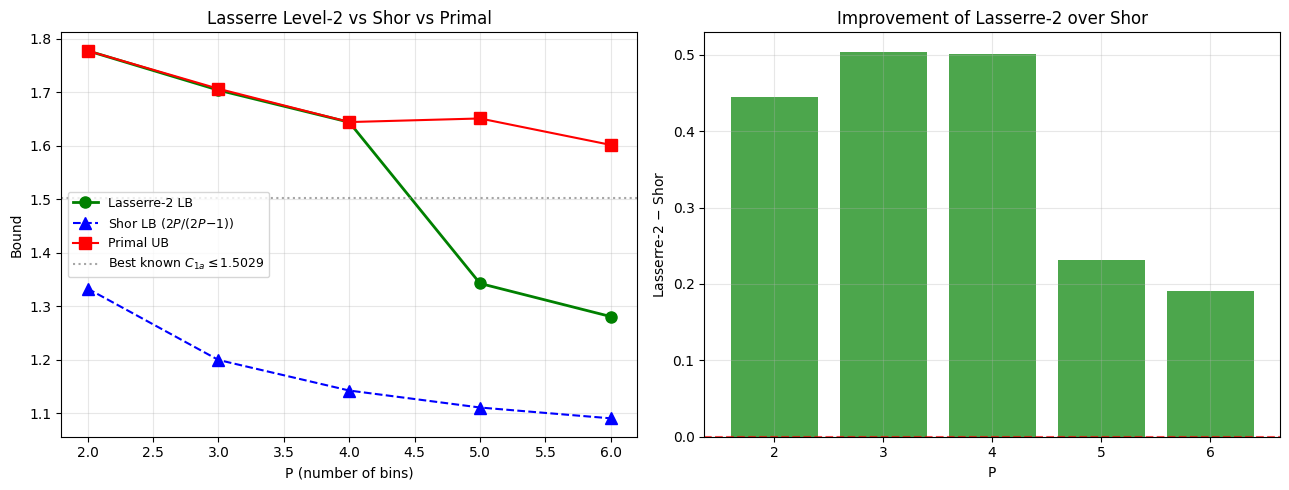


=== Lasserre-2 vs Shor comparison ===

P=2: Lasserre-2=1.77776623, Shor=1.33333333, improvement=+0.44443289
P=3: Lasserre-2=1.70410156, Shor=1.20000000, improvement=+0.50410156
P=4: Lasserre-2=1.64418030, Shor=1.14285714, improvement=+0.50132315
P=5: Lasserre-2=1.34291649, Shor=1.11111111, improvement=+0.23180538
P=6: Lasserre-2=1.28100681, Shor=1.09090909, improvement=+0.19009772


In [8]:
"""Cell 6: Results plot and analysis."""

if len(results) == 0:
    print("No results to plot.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
    Ps = [r['P'] for r in results]
    lass2 = [r['lasserre2'] for r in results]
    shors = [r['shor'] for r in results]
    primals = [r['primal'] for r in results]
    
    ax = axes[0]
    ax.plot(Ps, lass2, 'go-', label='Lasserre-2 LB', markersize=8, linewidth=2)
    ax.plot(Ps, shors, 'b^--', label='Shor LB ($2P/(2P{-}1)$)', markersize=8)
    ax.plot(Ps, primals, 'rs-', label='Primal UB', markersize=8)
    ax.axhline(y=1.5029, color='gray', linestyle=':', alpha=0.7,
               label='Best known $C_{1a} \\leq 1.5029$')
    ax.set_xlabel('P (number of bins)')
    ax.set_ylabel('Bound')
    ax.set_title('Lasserre Level-2 vs Shor vs Primal')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    # Show improvement: Lasserre-2 minus Shor
    improvements = [l - s for l, s in zip(lass2, shors)]
    ax.bar(Ps, improvements, color='green', alpha=0.7)
    ax.set_xlabel('P')
    ax.set_ylabel('Lasserre-2 $-$ Shor')
    ax.set_title('Improvement of Lasserre-2 over Shor')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('lasserre_level2_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n=== Lasserre-2 vs Shor comparison ===\n")
    for r in results:
        improv = r['lasserre2'] - r['shor']
        print(f"P={r['P']}: Lasserre-2={r['lasserre2']:.8f}, "
              f"Shor={r['shor']:.8f}, improvement={improv:+.8f}")

In [7]:
"""Cell 7: Diagnostic -- check moment matrix rank and flatness."""

# If the moment matrix has low rank (especially rank 1), the relaxation is tight
# and the optimal x can be extracted. Higher rank indicates remaining slack.

for r in results:
    P = r['P']
    print(f"\n--- P = {P} ---")
    print(f"  Lasserre-2 LB = {r['lasserre2']:.8f}")
    print(f"  Shor LB       = {r['shor']:.8f}")
    print(f"  Primal UB     = {r['primal']:.8f}")
    print(f"  M_2 rank      = {r['M_rank']} (out of d={r['d']})")
    if r.get('first_moments') is not None:
        x = r['first_moments']
        print(f"  E[x]          = {np.round(x, 5)}")
        print(f"  sum(E[x])     = {np.sum(x):.8f}")
        # Check if first moments correspond to a good primal candidate
        conv = np.convolve(x, x, mode='full')
        primal_from_moments = 2 * P * np.max(conv)
        print(f"  Primal from E[x]: {primal_from_moments:.6f}")
    if r['M_rank'] == 1:
        print(f"  >>> TIGHT: rank-1 solution, relaxation is exact!")


--- P = 2 ---
  Lasserre-2 LB = 1.77776623
  Shor LB       = 1.33333333
  Primal UB     = 1.77777778
  M_2 rank      = 2 (out of d=6)
  E[x]          = [0.5 0.5]
  sum(E[x])     = 1.00000000
  Primal from E[x]: 2.000000

--- P = 3 ---
  Lasserre-2 LB = 1.70410156
  Shor LB       = 1.20000000
  Primal UB     = 1.70666667
  M_2 rank      = 4 (out of d=10)
  E[x]          = [0.36253 0.27494 0.36253]
  sum(E[x])     = 0.99999999
  Primal from E[x]: 2.030687

--- P = 4 ---
  Lasserre-2 LB = 1.64418030
  Shor LB       = 1.14285714
  Primal UB     = 1.64446632
  M_2 rank      = 8 (out of d=15)
  E[x]          = [0.29405 0.20595 0.20595 0.29405]
  sum(E[x])     = 0.99999999
  Primal from E[x]: 2.062090

--- P = 5 ---
  Lasserre-2 LB = 1.34291649
  Shor LB       = 1.11111111
  Primal UB     = 1.65119682
  M_2 rank      = 7 (out of d=21)
  E[x]          = [0.26381 0.16263 0.14711 0.16263 0.26381]
  sum(E[x])     = 0.99999296
  Primal from E[x]: 2.137297

--- P = 6 ---
  Lasserre-2 LB = 1.281006

## Formulation Notes

### Why localizing matrices matter for the epigraph constraints

The discretized $C_{1a}$ problem is a **minimax** optimization:
$$\min_{x \in \Delta} \max_k \; 2P \sum_{i+j=k} x_i x_j$$

The epigraph reformulation introduces $\eta$:
$$\min \eta \quad \text{s.t.} \quad \eta - p_k(x) \geq 0 \;\;\forall k, \quad x \in \Delta$$

In the Lasserre hierarchy, each constraint $g(x) \geq 0$ is enforced via a **localizing matrix**
$M_{d-\lceil \deg g / 2\rceil}(g \cdot \mu) \succeq 0$, not merely the scalar $\mathbb{E}[g(x)] \geq 0$.

For $g_k = \eta - p_k(x)$ (degree 2), the level-2 localizing matrix is $M_1(g_k \cdot \mu)$,
a $(P{+}1) \times (P{+}1)$ PSD constraint with entries involving moments up to degree 4.
This enforces $\eta \geq p_k(x)$ **pointwise on the support**, not just in expectation.

Using only scalar constraints $\eta \geq \mathbb{E}[p_k]$ reduces to the Shor relaxation,
because distributions can equalize $\mathbb{E}[p_k]$ by spreading mass — but the localizing
matrix prevents this by requiring $p_k(x) \leq \eta$ everywhere.

### Bilinear structure and binary search

The localizing matrix $\eta \cdot M_1(\mu) - M_1(p_k \cdot \mu) \succeq 0$ is bilinear in
$(\eta, y)$, so we cannot optimize $\eta$ directly in a single SDP. Instead, we fix $\eta$
and solve a feasibility SDP, then binary search on $\eta$.

### Next steps

- If the Lasserre-2 bound significantly exceeds Shor, try larger $P$ to see scaling.
- If the bound approaches the primal value, the relaxation may be tight or near-tight.
- A rank-1 moment matrix certifies exact tightness and yields the optimal $x$.
- Level-3 Lasserre would use $M_2$ localizing matrices for $g_k$, at higher computational cost.